In [1]:
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
!xsv cat rows ./sampling-nasbench-points/*.csv > sampling-nasbench-points.csv

In [11]:
data1 = pd.read_csv("./sampling-nasbench-points.csv")
data1 = data1.rename(columns={"evaluation_time": "evaluation time"})
data1

,idx,source,solution,objective,evaluation time
0,0,archive_2022-11-07-long-scalability-ecga-nasbe...,1 2 1 5 2 2 3 0 5 3 5 2 1 1 6 0 5 0 1 6 0 2 1 ...,92.079430,3041.196312
1,1,archive_2022-11-07-long-scalability-ecga-nasbe...,1 2 6 5 2 1 4 2 0 3 2 2 3 2 3 2 5 0 6 0 6 0 2 ...,92.789658,3048.981467
2,2,archive_2022-11-07-long-scalability-ecga-nasbe...,2 0 1 2 0 0 3 0 2 7 5 5 4 5 1 6 2 2 2 0 2 0 5 ...,92.957596,3173.909902
3,3,archive_2022-11-07-long-scalability-ecga-nasbe...,2 6 4 0 2 3 0 0 1 5 1 5 0 5 6 2 5 2 1 2 0 2 1 ...,93.274055,3288.346852
4,4,archive_2022-11-07-long-scalability-ecga-nasbe...,2 2 6 1 0 3 2 0 3 8 0 1 5 4 2 1 4 1 4 1 3 0 2 ...,93.470421,3446.217595
...,...,...,...,...,...
5522,995,random_seed_42,6 3 0 1 2 0 5 0 1 1 0 1 3 4 2 5 2 5 3 5 6 6 4 ...,93.479980,4694.854573
5523,996,random_seed_42,1 2 0 3 0 3 5 1 5 7 1 4 5 5 4 0 3 6 0 4 3 1 2 ...,93.070999,4294.208255
5524,997,random_seed_42,0 1 2 6 1 4 8 2 3 8 2 4 5 0 0 1 5 3 1 5 0 1 3 ...,91.721512,4143.747635
5525,998,random_seed_42,2 2 4 2 1 0 1 1 5 7 2 6 1 6 2 0 0 6 4 1 6 0 2 ...,93.361725,3866.891808


In [12]:
data2 = pd.read_csv("./results/test-ef312c3/evaluations.csv.gz")
data2["source"] = "evaluations-" + data2["algorithm_type"]
data2["objective"] = -data2["objectives"]
remapping = {
    "#evaluations": "idx",
    "source": "source",
    "genotype (categorical)": "solution",
    "objective": "objective",
    "time_spent": "evaluation time",
}
data2rmp = data2.rename(columns=remapping)[remapping.values()]

In [ ]:
# both
data = pd.concat([data1, data2rmp])

In [ ]:
data = data1

In [15]:
data = data2rmp

In [34]:
import scipy.stats

<AxesSubplot: xlabel='objective', ylabel='evaluation time'>

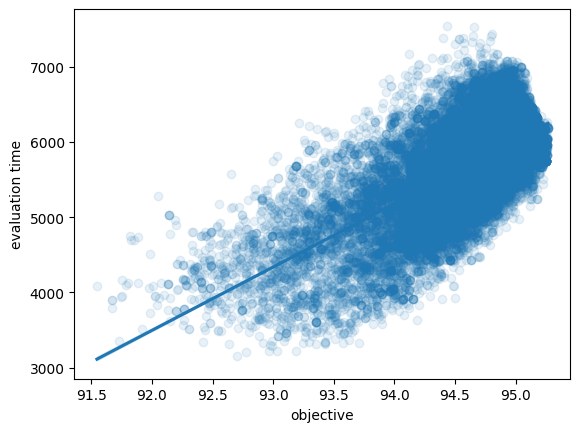

In [40]:
sns.regplot(data=data, x="objective", y="evaluation time", fit_reg=True, scatter_kws={'alpha':0.1})

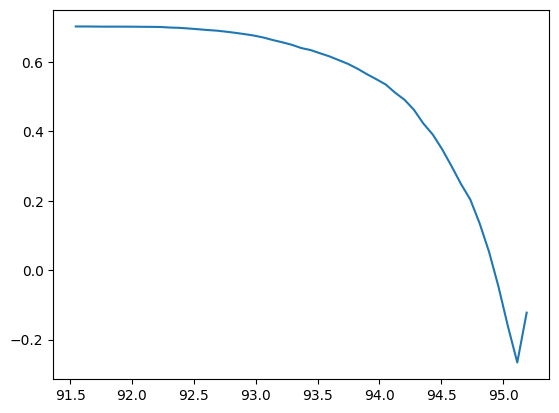

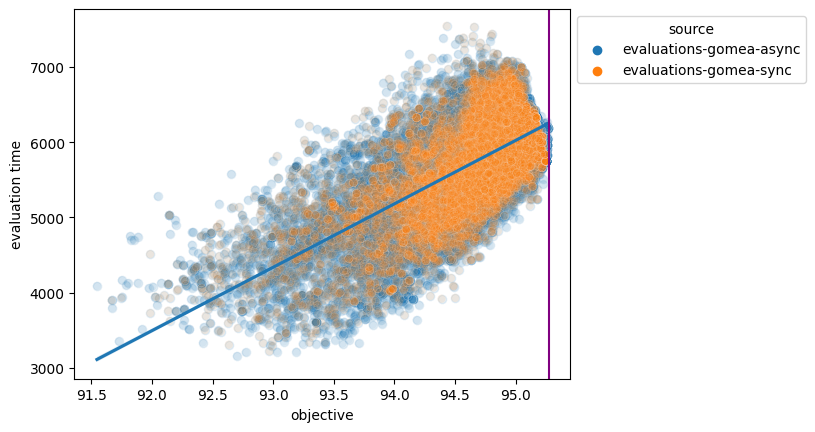

In [39]:
# def compute_rsq(c1, c2):
    # lf = np.polynomial.Polynomial.fit(c1,  c2, 1)
    # return np.sum((lf(c1) -  c2)**2) / np.sum(( c2 - np.mean( c2))**2)
def for_th(th):
    data_th = data[data["objective"] > th]
    return scipy.stats.linregress(data_th["objective"], data_th["evaluation time"])[2]
xs =  np.linspace(data["objective"].min(), data["objective"].max(), 50)[:-1]
ys = np.array([for_th(th) for th in xs])
plt.plot(xs, ys)
plt.show()
sns.regplot(data=data, x="objective", y="evaluation time", fit_reg=True, scatter_kws={'alpha':0.1})
ax = sns.scatterplot(data=data, x="objective", y="evaluation time", hue="source", alpha=0.1)
sns.move_legend(ax, bbox_to_anchor=(1,1), loc="upper left")
plt.axvline(95.2727, color="purple")

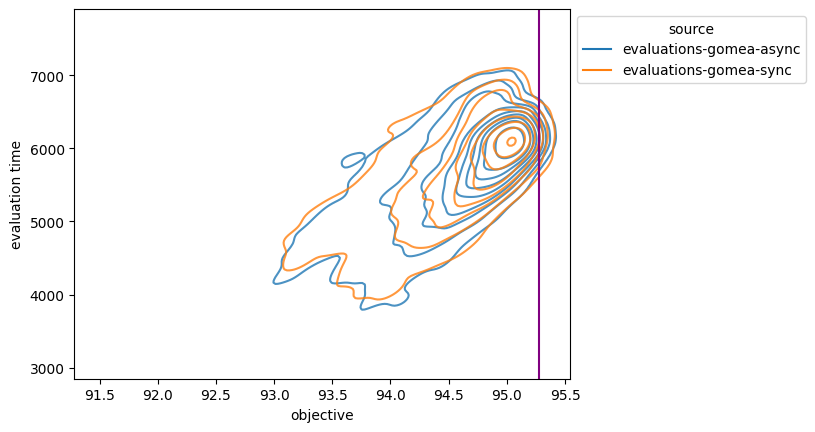

In [23]:
ax = sns.kdeplot(data=data, x="objective", y="evaluation time", hue="source", alpha=0.8)
plt.axvline(95.2727, color="purple")
sns.move_legend(ax, bbox_to_anchor=(1,1), loc="upper left")

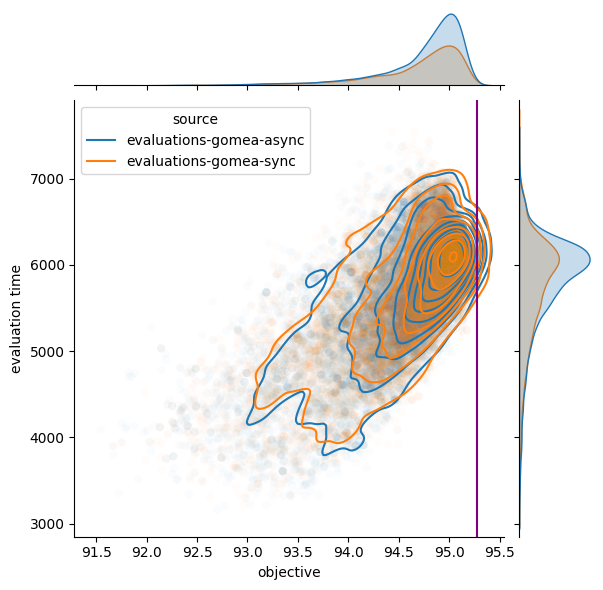

In [28]:
g = sns.jointplot(data=data, x="objective", y="evaluation time", hue="source", alpha=0.02)
g.plot_joint(sns.kdeplot)
plt.axvline(95.2727, color="purple")
# sns.move_legend(g, bbox_to_anchor=(1,1), loc="upper left")

In [ ]:
#sidenote: these points are - by how they are collected - biased towards lower evaluation times.

In [65]:
import sklearn.ensemble
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.dummy

In [74]:
X = np.array([[int(n) for n in r] for r in data["solution"].str.split()])
y = data["evaluation time"]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y.to_numpy(), train_size=0.5, test_size=0.5, random_state=42)

In [59]:
linear_model = sklearn.pipeline.Pipeline([('enc', sklearn.preprocessing.OneHotEncoder()), ('cls', sklearn.linear_model.LinearRegression())])
tree_model = sklearn.pipeline.Pipeline([('enc', sklearn.preprocessing.OneHotEncoder()), ('cls', sklearn.ensemble.RandomForestRegressor())])
dummy_model = sklearn.pipeline.Pipeline([('enc', sklearn.preprocessing.OneHotEncoder()), ('cls', sklearn.dummy.DummyRegressor())])

In [75]:
linear_model.fit(X_train, y_train)
tree_model.fit(X_train, y_train)
dummy_model.fit(X_train, y_train)

NameError: name 'dummy_model' is not defined

In [79]:
dict(zip(linear_model['enc'].get_feature_names_out(), linear_model['cls'].coef_))

{'x0_0': -357.5699099629733,
 'x0_1': -238.88309167670505,
 'x0_2': -176.8865524707454,
 'x0_3': 315.16658435858074,
 'x0_4': 414.5902641609902,
 'x0_5': -17.363997511111066,
 'x0_6': 60.94670310195706,
 'x1_0': -214.9380615838385,
 'x1_1': -239.11811461432524,
 'x1_2': -196.4290507458346,
 'x1_3': 313.59644907178694,
 'x1_4': 412.45764472793275,
 'x1_5': -97.27765909912897,
 'x1_6': 21.70879224339816,
 'x2_0': -85.33544792069125,
 'x2_1': -84.90364246457499,
 'x2_2': 62.177980405702264,
 'x2_3': 62.78972557470808,
 'x2_4': 137.01796067619892,
 'x2_5': -73.38307528440225,
 'x2_6': -18.36350098694404,
 'x3_0': -111.10584733459889,
 'x3_1': -103.92019729933335,
 'x3_2': 55.053060840088975,
 'x3_3': 114.83482746888507,
 'x3_4': 165.77070746872388,
 'x3_5': -88.98042658086374,
 'x3_6': -31.65212456290219,
 'x4_0': -43.38982928205694,
 'x4_1': 27.796136724896495,
 'x4_2': 15.59369255718286,
 'x5_0': 6.667976409956396,
 'x5_1': 2.203001050393944,
 'x5_2': -35.22403005588424,
 'x5_3': 16.4938

In [80]:
import sklearn.metrics

[
sklearn.metrics.mean_squared_error(linear_model.predict(X_test), y_test), 
sklearn.metrics.mean_squared_error(tree_model.predict(X_test), y_test),
sklearn.metrics.mean_squared_error(dummy_model.predict(X_test), y_test)
]

[145472.7172024459, 147659.24769832753, 1009211.9803689239]

<AxesSubplot: >

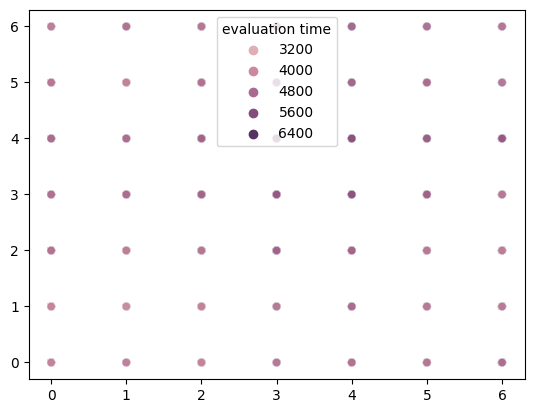

In [46]:
sns.scatterplot(data=data, x=X[:, 0], y=X[:, 1], hue="evaluation time", alpha=0.1)

<AxesSubplot: ylabel='evaluation time'>

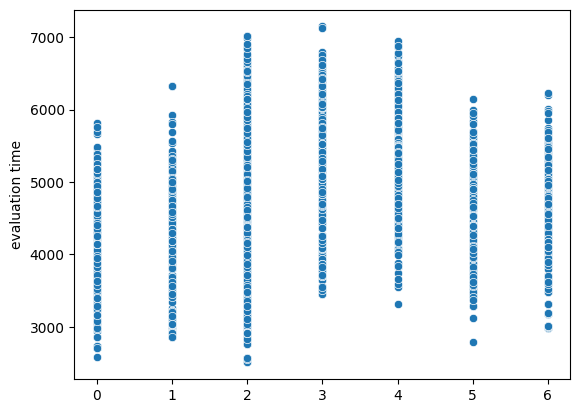

In [43]:
sns.scatterplot(data=data, x=X[:, 0], y="evaluation time")

<AxesSubplot: ylabel='evaluation time'>

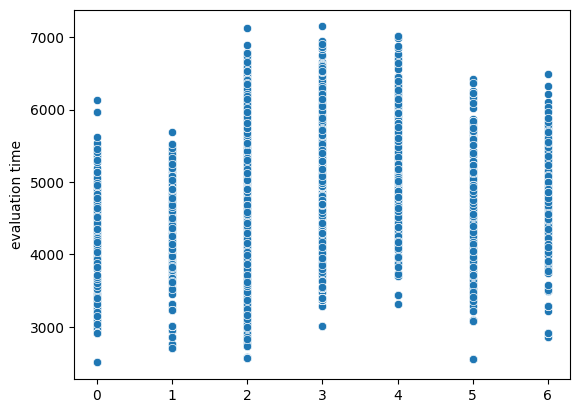

In [47]:
sns.scatterplot(data=data, x=X[:, 1], y="evaluation time")

<AxesSubplot: ylabel='evaluation time'>

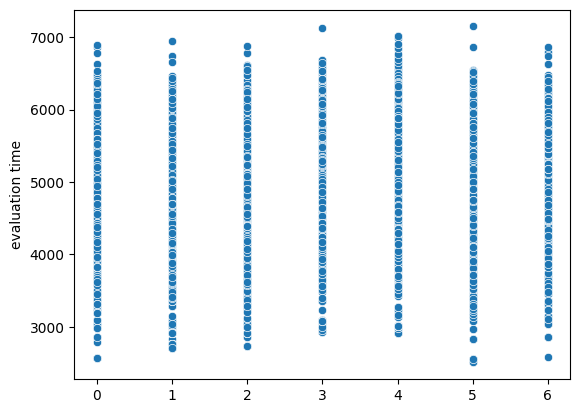

In [48]:
sns.scatterplot(data=data, x=X[:, 11], y="evaluation time")